In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as datasets

In [2]:
splits_df = pd.read_csv('data/mj_splits_training_testing.csv')
labels    = np.repeat(np.array(splits_df['label']), 2)
training  = np.repeat(np.array(splits_df['training']), 2)
names     = np.repeat(np.array(splits_df['subject']), 2)

In [3]:
train_file = np.load("data/standard_fcs_labels_training.npz")

In [4]:
labels = train_file["labels"]
inputs = train_file["standard_fcs"]

In [5]:
x_train, x_test = inputs[training == 1], inputs[training == 0]
y_train, y_test = labels[training == 1], labels[training == 0]

In [6]:
import shinetools as shine
import importlib
importlib.reload(shine)

import sys
stdout = sys.stdout

In [7]:
model = shine.ExposedWeightsModel(4005)
model.compile(optim.Adam, 1e-4, "l2", 0.05, 1)

In [8]:
dataloader = shine.get_dataloader(x_train, y_train, 32)
test_dataloader = shine.get_dataloader(x_test, y_test, 32)

In [9]:
model.fit(dataloader, verbose=True, epochs=5, validation=test_dataloader)

 epoch 1/5, iter 5/5, avg_loss: 2.847752583026886 acc: 0.6318, auc: 0.6739096641540527, test_loss: 0.7633266687393189, test_acc: 0.6923, test_auc: 0.7610946893692017
 epoch 2/5, iter 5/5, avg_loss: 2.336823433637619 acc: 0.7616, auc: 0.8409376740455627, test_loss: 0.6982176423072814, test_acc: 0.7769, test_auc: 0.79832345247268683
 epoch 3/5, iter 5/5, avg_loss: 2.003798621892929 acc: 0.8391, auc: 0.9073183536529541, test_loss: 0.6664527535438538, test_acc: 0.7769, test_auc: 0.80473375320434571
 epoch 4/5, iter 5/5, avg_loss: 1.7293229043483733 acc: 0.8605, auc: 0.9405008554458618, test_loss: 0.6365756660699844, test_acc: 0.7846, test_auc: 0.8160749673843384
 epoch 5/5, iter 5/5, avg_loss: 1.4120904684066773 acc: 0.905, auc: 0.9705253839492798, test_loss: 0.6400772869586945, test_acc: 0.7692, test_auc: 0.8286489248275757


In [10]:
import sklearn
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold

In [11]:
sklearn.metrics.roc_auc_score

<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>

In [476]:
y_test.shape

(130,)

Training model NN, fold 1/5
 epoch 1/4, iter 4/4, avg_loss: 3.0477330833673477 acc: 0.6311, auc: 0.6517850756645203, test_loss: 0.9235505312681198, test_acc: 0.5865, test_auc: 0.5722028613090515
 epoch 2/4, iter 4/4, avg_loss: 2.5047639161348343 acc: 0.7621, auc: 0.8133146166801453, test_loss: 0.9058965146541595, test_acc: 0.5962, test_auc: 0.5981416702270508
 epoch 3/4, iter 4/4, avg_loss: 2.2197101935744286 acc: 0.8131, auc: 0.8845936059951782, test_loss: 0.909892737865448, test_acc: 0.5769, test_auc: 0.63375914096832283
 epoch 4/4, iter 4/4, avg_loss: 1.9351159408688545 acc: 0.8592, auc: 0.9308892488479614, test_loss: 0.8537673950195312, test_acc: 0.625, test_auc: 0.6701509952545166
Training model NN, fold 2/5
 epoch 1/4, iter 4/4, avg_loss: 3.0626168698072433 acc: 0.5908, auc: 0.5870183706283569, test_loss: 0.8891289383172989, test_acc: 0.5631, test_auc: 0.5511407852172852
 epoch 2/4, iter 10/13, avg_loss: 0.7867454051971435 acc: 0.7469, auc: 0.8165515661239624

KeyboardInterrupt: 

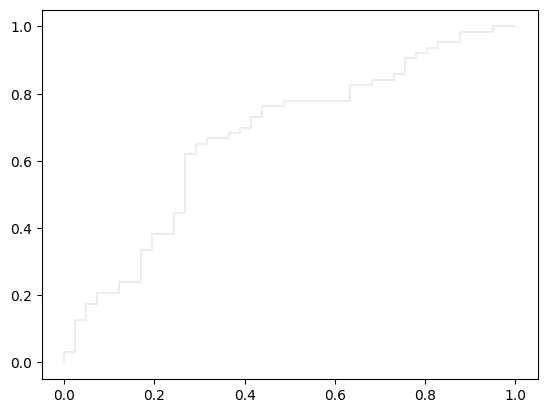

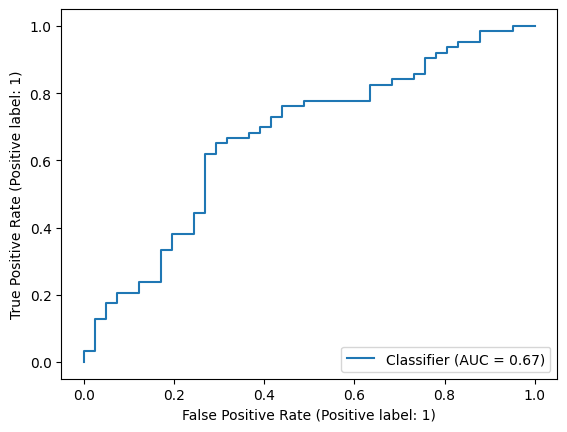

In [464]:
fig, ax = plt.subplots()

metrics = {}
folds = 5
tprs = []
base_fpr = np.linspace(0, 1, 101)
skf = StratifiedKFold(folds)

for j, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Training model NN, fold {j+1}/{folds}")

    metrics[j] = {}
    model_cln = shine.ExposedWeightsModel(4005)
    model_cln.compile(optim.Adam, 1e-4, "l2", 0.05, 0.1)
    
    fold_x_train, fold_x_test = x_train[train_index], x_train[test_index]
    fold_y_train, fold_y_test = y_train[train_index], y_train[test_index]

    model_cln.fit(shine.get_dataloader(fold_x_train, fold_y_train, 32),
                  epochs=4, validation=shine.get_dataloader(fold_x_test, fold_y_test, 32), verbose=True)
    test_pred = torch.sigmoid(model_cln.predict(shine.torch_form(fold_x_test)).detach()).numpy()
    
    metrics[j]["auc"] = sklearn.metrics.roc_auc_score(fold_y_test, test_pred)
    metrics[j]["acc"] = np.sum(np.round(test_pred) == fold_y_test)

    viz_data = sklearn.metrics.RocCurveDisplay.from_predictions(fold_y_test, test_pred)
    fpr = viz_data.fpr
    tpr = viz_data.tpr
    #fpr, tpr, _ = sklearn.metrics.roc_curve(fold_y_test, probs)

    metrics[j]["fpr_tpr"] = (fpr, tpr)

    #roc = sklearn.metrics.RocCurveDisplay.from_estimator(model_cln, fold_x_test, fold_y_test).plot(ax)
    roc = ax.plot(fpr, tpr, alpha=0.15, color="gray", label=f"Train Fold {j}, AUROC: {np.round(metrics[j]['auc'], 3)}")
    metrics[j]["roc_plot"] = roc

    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

    #print(f"Training model {model_name}, fold {j}/{folds} prop 1 train: {fold_y_train.mean()}, prop 1  test: {fold_y_test.mean()}")

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)

aucs = [m['auc'] for _, m in metrics.items()]
mean_auc = np.mean(aucs)
sd_auc = np.std(aucs)

ci = 0.95 * sd_auc / np.sqrt(len(aucs))

ax.plot(base_fpr, mean_tprs, color="#FFFE89", label=f"Average AUC: {np.round(mean_auc, 3)}, +- {np.round(ci, 3)}")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title="nn model")


In [16]:
model = shine.ExposedWeightsModel(4005)
model.compile(optim.Adam, 1e-4, "l2", 0, 1)

In [17]:
dataloader = shine.get_dataloader(x_train, y_train, 32)
test_dataloader = shine.get_dataloader(x_test, y_test, 32)

In [18]:
model.fit(dataloader, verbose=True, epochs=5, validation=test_dataloader)

 epoch 1/5, iter 5/5, avg_loss: 2.049292004108429 acc: 0.5988, auc: 0.632949948310852, test_loss: 0.5449489504098892, test_acc: 0.7231, test_auc: 0.7869822978973389
 epoch 2/5, iter 5/5, avg_loss: 1.327776950597763 acc: 0.8023, auc: 0.8726589679718018, test_loss: 0.5508706748485566, test_acc: 0.7462, test_auc: 0.79561150074005134
 epoch 3/5, iter 5/5, avg_loss: 0.9910479813814164 acc: 0.8488, auc: 0.9197146892547607, test_loss: 0.5310326382517815, test_acc: 0.8, test_auc: 0.8412228226661682279
 epoch 4/5, iter 5/5, avg_loss: 0.7858368694782257 acc: 0.8585, auc: 0.9327394962310791, test_loss: 0.9075497120618821, test_acc: 0.7231, test_auc: 0.8272929191589355
 epoch 5/5, iter 5/5, avg_loss: 0.64248156696558 acc: 0.8779, auc: 0.9400609731674194, test_loss: 0.5616450130939483, test_acc: 0.7846, test_auc: 0.84368836879730221


In [19]:
pred_weights = model(shine.torch_form(x_test))[1].detach().numpy()
pred_weights.shape

(130, 4005)

In [20]:
import seaborn as sns
import tqdm

In [21]:
def get_fc_from_grad(grad):
    fc = np.zeros((90, 90))
    fc[0, 0] = 0
    c = 0
    for i in range(90):
        for j in range(i+1, 90):
            #print(fc[i, j], gr)
            #print(i, j, c)
            fc[i, j] = grad[c]
            c += 1

    c = 0
    fc = fc.T     
    for i in range(90):
        for j in range(i+1, 90):
            #print(fc[i, j], gr)
            #print(i, j, c)
            fc[i, j] = grad[c]
            c += 1
    
    return fc

In [22]:
fcs = []
bcs = []

for i in tqdm.tqdm(range(x_test.shape[0])):
    fcs.append(get_fc_from_grad(pred_weights[i]))
    bcs.append(get_fc_from_grad(x_test[i]))

100%|████████████████████████████████████████| 130/130 [00:00<00:00, 148.02it/s]


<Axes: >

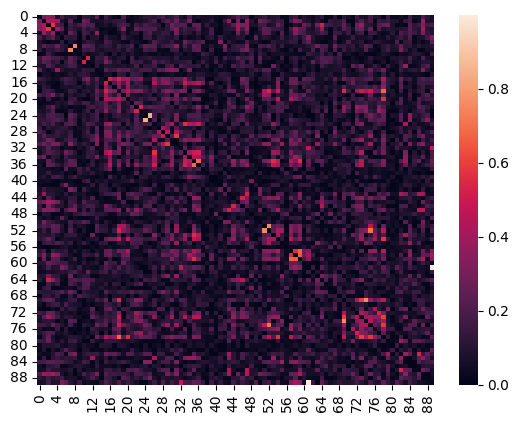

In [23]:
sns.heatmap(np.abs(bcs[0]))

<Axes: >

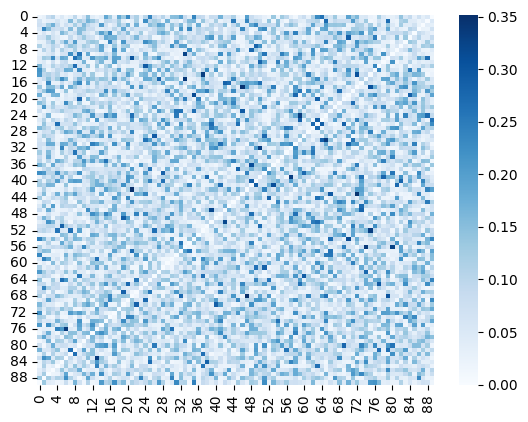

In [24]:
sns.heatmap(np.rot90(np.mean(np.abs(fcs), axis=0)), cmap="Blues")

In [625]:
def argsort(mat):
    return np.dstack(np.unravel_index(np.argsort(mat.flatten()), mat.shape))

argsort(np.array([[1, 2], [0, 1]]))

array([[[1, 0],
        [0, 0],
        [1, 1],
        [0, 1]]])

In [25]:
fbfcs = [np.abs(i*j) for i, j in zip(fcs, bcs)]
fc_thresh = [np.copy(a) for a in fcs]
threshv = 0.02
thresh = [np.percentile(f, (1-threshv)*100) for f in fbfcs]
threshv = 0.02
threshfc = [np.percentile(f, (1-threshv)*100) for f in fcs]
for i, (f, t) in enumerate(zip(fbfcs, thresh)):
    f[f < t] = 0
    f[f >= t] = 1
    fbfcs[i] = f
    
for i, (f, t) in enumerate(zip(fc_thresh, threshfc)):
    f[f < t] = 0
    f[f >= t] = 1
    fc_thresh[i] = f

avg_fcm = np.mean(fbfcs, axis=0)
avg_fcm.shape

(90, 90)

<Axes: >

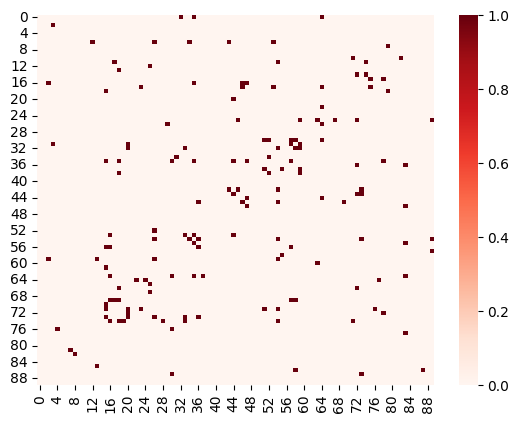

In [26]:
sns.heatmap(np.rot90(np.abs(fbfcs[0])), cmap="Reds")

In [27]:
degree_centralities = []
for f in fbfcs:
    centralities = []
    for i in range(90):
        centralities.append(np.mean(f[i]))
    degree_centralities.append(centralities)

In [28]:
centrals = np.array(degree_centralities)
centrals.shape

(130, 90)

In [29]:
median_centrals = np.median(centrals.T, axis=1)

In [30]:
indices = np.argpartition(median_centrals, -20)[-20:]
indices.shape

(20,)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
 

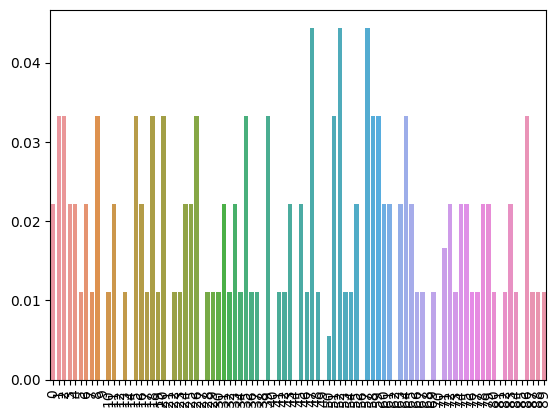

In [31]:
sns.barplot(x=np.arange(median_centrals.shape[0]), y=median_centrals)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, '4'),
  Text(1, 0, '15'),
  Text(2, 0, '16'),
  Text(3, 0, '18'),
  Text(4, 0, '22'),
  Text(5, 0, '23'),
  Text(6, 0, '26'),
  Text(7, 0, '28'),
  Text(8, 0, '29'),
  Text(9, 0, '33'),
  Text(10, 0, '35'),
  Text(11, 0, '52'),
  Text(12, 0, '57'),
  Text(13, 0, '59'),
  Text(14, 0, '69'),
  Text(15, 0, '75'),
  Text(16, 0, '82'),
  Text(17, 0, '83'),
  Text(18, 0, '86'),
  Text(19, 0, '87')])

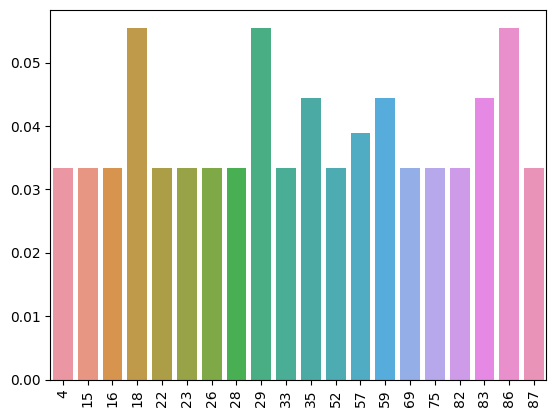

In [633]:
sns.barplot(x=np.arange(median_centrals.shape[0])[indices], y=median_centrals[indices])
plt.xticks(rotation=90)

In [32]:
import pandas as pd

roi_labels = pd.read_table('data/stanford_coord_mapping_nonetwork.tsv')
roi_labels.head()

,Unnamed: 0,stanford_name,coordinates,description,parcel_ind
0,0,ant_sal_1,"[-32, 48, 20]",L prefrontal cortex,0
1,1,ant_sal_2,"[-42, 14, -4]",L anterior insula,1
2,2,ant_sal_3,"[0, 18, 44]",bilateral ACC,2
3,3,ant_sal_4,"[28, 45, 27]",R frontal gyrus,3
4,4,ant_sal_5,"[45, 13, 0]",R anterior insula,4


In [33]:
df_raw = {"person": [], "roi": [], "centrality": []}
for i in range(centrals.shape[0]):
    for j in range(centrals.shape[1]):
        if j not in indices:
            continue
        df_raw["person"].append(i)
        df_raw["roi"].append(roi_labels.description[j])
        df_raw["centrality"].append(centrals[i, j])

df_raw

{'person': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,
  9,


In [34]:
df = pd.DataFrame(df_raw)
df

,person,roi,centrality
0,0,L anterior insula,0.000000
1,0,bilateral ACC,0.022222
2,0,R superior temporal/auditory,0.011111
3,0,bilateral mPFC,0.077778
4,0,bilateral posterior cingulate,0.066667
...,...,...,...
2595,129,R inferior parietal/angular gyrus,0.055556
2596,129,R pre/post-central gyri,0.066667
2597,129,R middle frontal gyrus,0.011111
2598,129,R superior frontal gyrus,0.000000


In [35]:
df[df.centrality < 0]

,person,roi,centrality


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'L anterior insula'),
  Text(1, 0, 'bilateral ACC'),
  Text(2, 0, 'R superior temporal/auditory'),
  Text(3, 0, 'bilateral mPFC'),
  Text(4, 0, 'bilateral posterior cingulate'),
  Text(5, 0, 'R lateral angular gyrus'),
  Text(6, 0, 'L inferior frontal gyrus'),
  Text(7, 0, 'R mid-temporal cortex'),
  Text(8, 0, 'L inferior parietal/angular gyrus'),
  Text(9, 0, 'L middle frontal gyrus'),
  Text(10, 0, 'L superior temporal gyrus'),
  Text(11, 0, 'bilateral mid-posterior cingulate'),
  Text(12, 0, 'bilateral medial posterior precuneus'),
  Text(13, 0, 'R middle frontal/dlPFC'),
  Text(14, 0, 'R middle orbito-frontal cortex'),
  Text(15, 0, 'R inferior parietal/angular gyrus'),
  Text(16, 0, 'R pre/post-central gyri'),
  Text(17, 0, 'R middle frontal gyrus'),
  Text(18, 0, 'R superior frontal gyrus'),
  Text(19, 0, 'R inferior temporal cortex')])

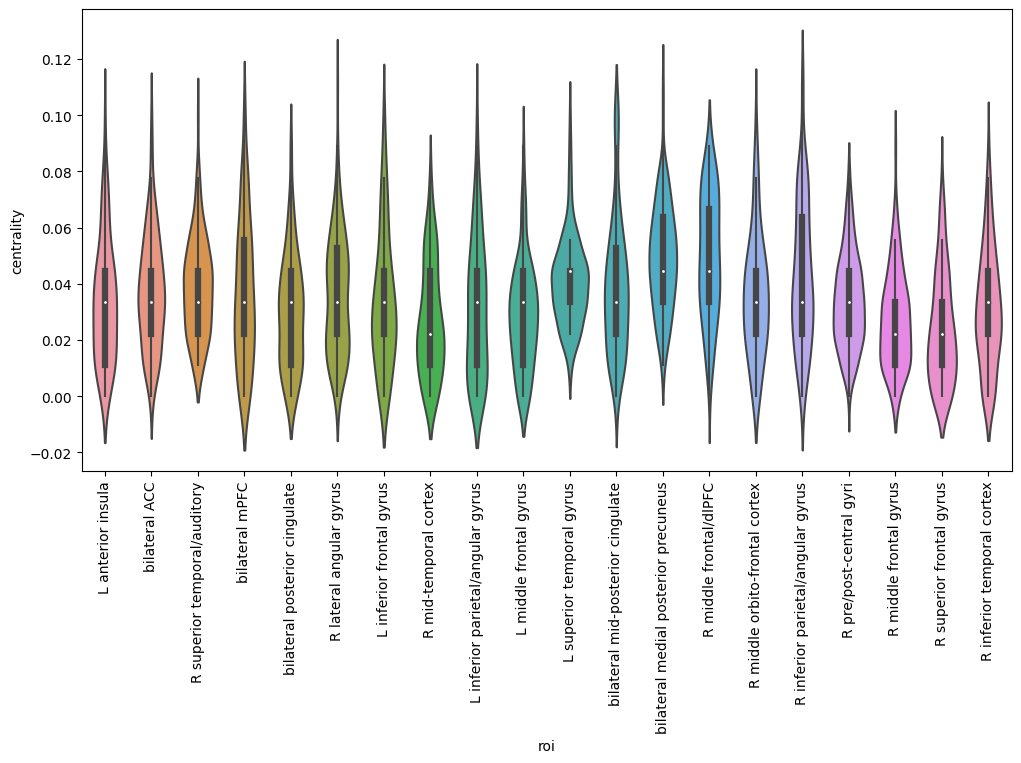

In [36]:
fig = plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="roi", y="centrality")
plt.xticks(rotation=90)
